In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# 데이터 뜯어 보기

## 전체적 경향
- 본 데이터는 10분마다 측정한 데이터임
- 일일 누적 일사량이 144개마다 0으로 리셋되는 것을 보아 0시 0분부터 측정된 데이터라 유추할 수 있음
- X14, X16, X19는 train, test에서 모두 0 -> 삭제
- 기온 변수가 있는데 이는 대기 온도를 뜻하고 온도는 따뜻함과 차가움의 정도를 나타냄

## 일일 누적 일사량, 강수량
- 10분 간 데이터와 30분 간 누적 데이터를 추출

## 풍향
- 0부터 360까지라 각도를 나타냄. 사인 함수로 변형

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import random

np.random.seed(123)
random.seed(123)

train = pd.read_csv('/gdrive/My Drive/Data/train1.csv')
test = pd.read_csv('/gdrive/My Drive/Data/test1.csv')
test.index = test.id
sample_sub = pd.read_csv('/gdrive/My Drive/Data/sample_submission1.csv')
df = pd.concat([train,test],axis=0,sort=False)
df.drop(['X14','X16','X19'],axis=1, inplace=True)
for col in df.columns:
  col_type = df[col].dtypes
  if str(col_type)[:3] == 'int':
    df[col] = df[col].astype(np.int16)
  else:
    df[col] = df[col].astype(np.float32)

# df[["X02", "X03", "X18", "X24", "X26"]] = np.log(df[["X02", "X03", "X18", "X24", "X26"]]+2)
df_dew = df[["X05","X08","X09","X23","X33"]]
df_dew1 = df[["X01","X06","X22","X27","X29"]]

df_atm = pd.DataFrame()
for col1 in df_dew.columns:
  for col2 in df_dew1.columns:
    df[col1+" / "+col2] = df_dew[col1] / df_dew1[col2]
    df[col1+" - "+col2] = df_dew[col1] - df_dew1[col2]
df["sea_press_mean"] = df_dew.mean(axis=1)
df["sea_press_sd"] = df_dew.std(axis=1)
df.drop(df_dew.columns,axis=1,inplace=True)
# df.drop(df_dew1.columns,axis=1,inplace=True)

near_zero_wind = np.array(df[df[["X02", "X03", "X18", "X24", "X26"]].sum(axis=1)<1].index)

df_wind = pd.DataFrame()
df_sun_rain = pd.DataFrame()
bins = [-0.1,90,180,270,360.1]
cols = ["X13","X15","X17","X25","X35"]
for i in cols:
  df_wind[i] = pd.cut(df[i],bins,labels = [1,2,3,4])
  df_wind[i] = df_wind[i].astype(np.int8) 

df_wind.loc[near_zero_wind,["X13","X15","X17","X25","X35"]] = 0
df.drop(["X13","X15","X17","X25","X35"],axis=1, inplace=True)

df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]] = df[["X04","X10","X11","X21","X34","X36","X39"]] - df[["X04","X10","X11","X21","X34","X36","X39"]].shift(1).fillna(0)
df_sun_rain.loc[np.arange(0,df.shape[0],144),["X04","X10","X11","X21","X34","X36","X39"]] = 0
df_sun_rain[["X04_diff","X10_diff","X11_diff","X21_diff","X34_diff","X36_diff","X39_diff"]] = df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]] + df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]].shift(1).fillna(0) +df_sun_rain[["X04","X10","X11","X21","X34","X36","X39"]].shift(1).fillna(2)

df.drop(["X04","X10","X11","X21","X34","X36","X39"],axis=1, inplace=True)


y_col = df.loc[:,"Y00":"Y18"].columns
df1 = df[y_col]
df.drop(y_col,axis=1,inplace=True)


minute = (df.id%144).astype(int)
hour= pd.Series((df.index%144/6).astype(int))
min_in_day = 144
hour_in_day = 24

minute_sin = np.sin(2*np.pi*minute/min_in_day) 
minute_cos = np.cos(2*np.pi*minute/min_in_day)
hour_sin  = np.sin(2*np.pi*hour/hour_in_day)
hour_cos  = np.cos(2*np.pi*hour/hour_in_day)

df_wind["minute_sin"], df_wind["minute_cos"],df_wind["hour_sin"],df_wind["hour_cos"] = minute_sin, minute_cos, hour_sin, hour_cos
df = pd.concat([df,df_sun_rain,df_wind,df1],axis=1,sort=False)
x_col = df.loc[:,"X00":"X39_diff"].columns
x_col1 = df.loc[:,"X13":"hour_cos"].columns
y_col = df.loc[:,"Y00":"Y17"].columns
train = df.iloc[:train.shape[0],:]
test = df.iloc[train.shape[0]:,:]

def standardization(df):
    dfmax = df.max()
    dfmin = df.min()
    norm = (df - dfmin) / (dfmax - dfmin)
    return norm, dfmin, dfmax
train_norm, train_min, train_max = standardization(train[x_col])
test_norm = (test[x_col] - train_min) / (train_max - train_min)

train1 = pd.concat([train_norm, train[x_col1]], axis=1) 
test1  = pd.concat([test_norm, test[x_col1]] , axis=1)

In [0]:
train2 = train1.iloc[:4320,:]
train3 = train1.iloc[4320:,:].reset_index(drop=True)
train_y = train.iloc[:4320,][y_col]
train18 = train.loc[4320:,"Y18"].reset_index(drop=True)

In [5]:
train1.shape

(4752, 95)

In [11]:
for column in train.columns:
    print('{} : {}'.format(column,round(train[column].var(),6),2))

id : 1882188.0
X00 : 22.161324
X01 : 11.289017
X02 : 1.148863
X03 : 0.876375
X06 : 11.585205
X07 : 19.159971
X12 : 496.312561
X18 : 1.334097
X20 : 476.566101
X22 : 11.341754
X24 : 1.190962
X26 : 1.539828
X27 : 11.87823
X28 : 17.852304
X29 : 11.493486
X30 : 463.355286
X31 : 30.47324
X32 : 27.79015
X37 : 381.311554
X38 : 337.393097
X05 / X01 : 0.0
X05 - X01 : 0.09941
X05 / X06 : 0.0
X05 - X06 : 0.142297
X05 / X22 : 0.0
X05 - X22 : 0.011642
X05 / X27 : 0.0
X05 - X27 : 0.2294
X05 / X29 : 0.0
X05 - X29 : 0.066347
X08 / X01 : 0.0
X08 - X01 : 0.310621
X08 / X06 : 0.0
X08 - X06 : 0.178876
X08 / X22 : 0.0
X08 - X22 : 0.280678
X08 / X27 : 0.0
X08 - X27 : 0.315114
X08 / X29 : 0.0
X08 - X29 : 0.232407
X09 / X01 : 0.0
X09 - X01 : 0.234165
X09 / X06 : 0.0
X09 - X06 : 0.319828
X09 / X22 : 0.0
X09 - X22 : 0.324402
X09 / X27 : 1e-06
X09 - X27 : 0.544474
X09 / X29 : 0.0
X09 - X29 : 0.341129
X23 / X01 : 0.0
X23 - X01 : 0.125678
X23 / X06 : 0.0
X23 - X06 : 0.086572
X23 / X22 : 0.0
X23 - X22 : 0.06012
X23 

In [0]:
def convert_to_timeseries(df, interval):
    sequence_list = []
    target_list = []
    
    for i in tqdm(range(df.shape[0] - interval)):
        sequence_list.append(np.array(df.iloc[i:i+interval,:-1]))
        target_list.append(df.iloc[i+interval,-1])
    
    sequence = np.array(sequence_list)
    target = np.array(target_list)
    
    return sequence, target



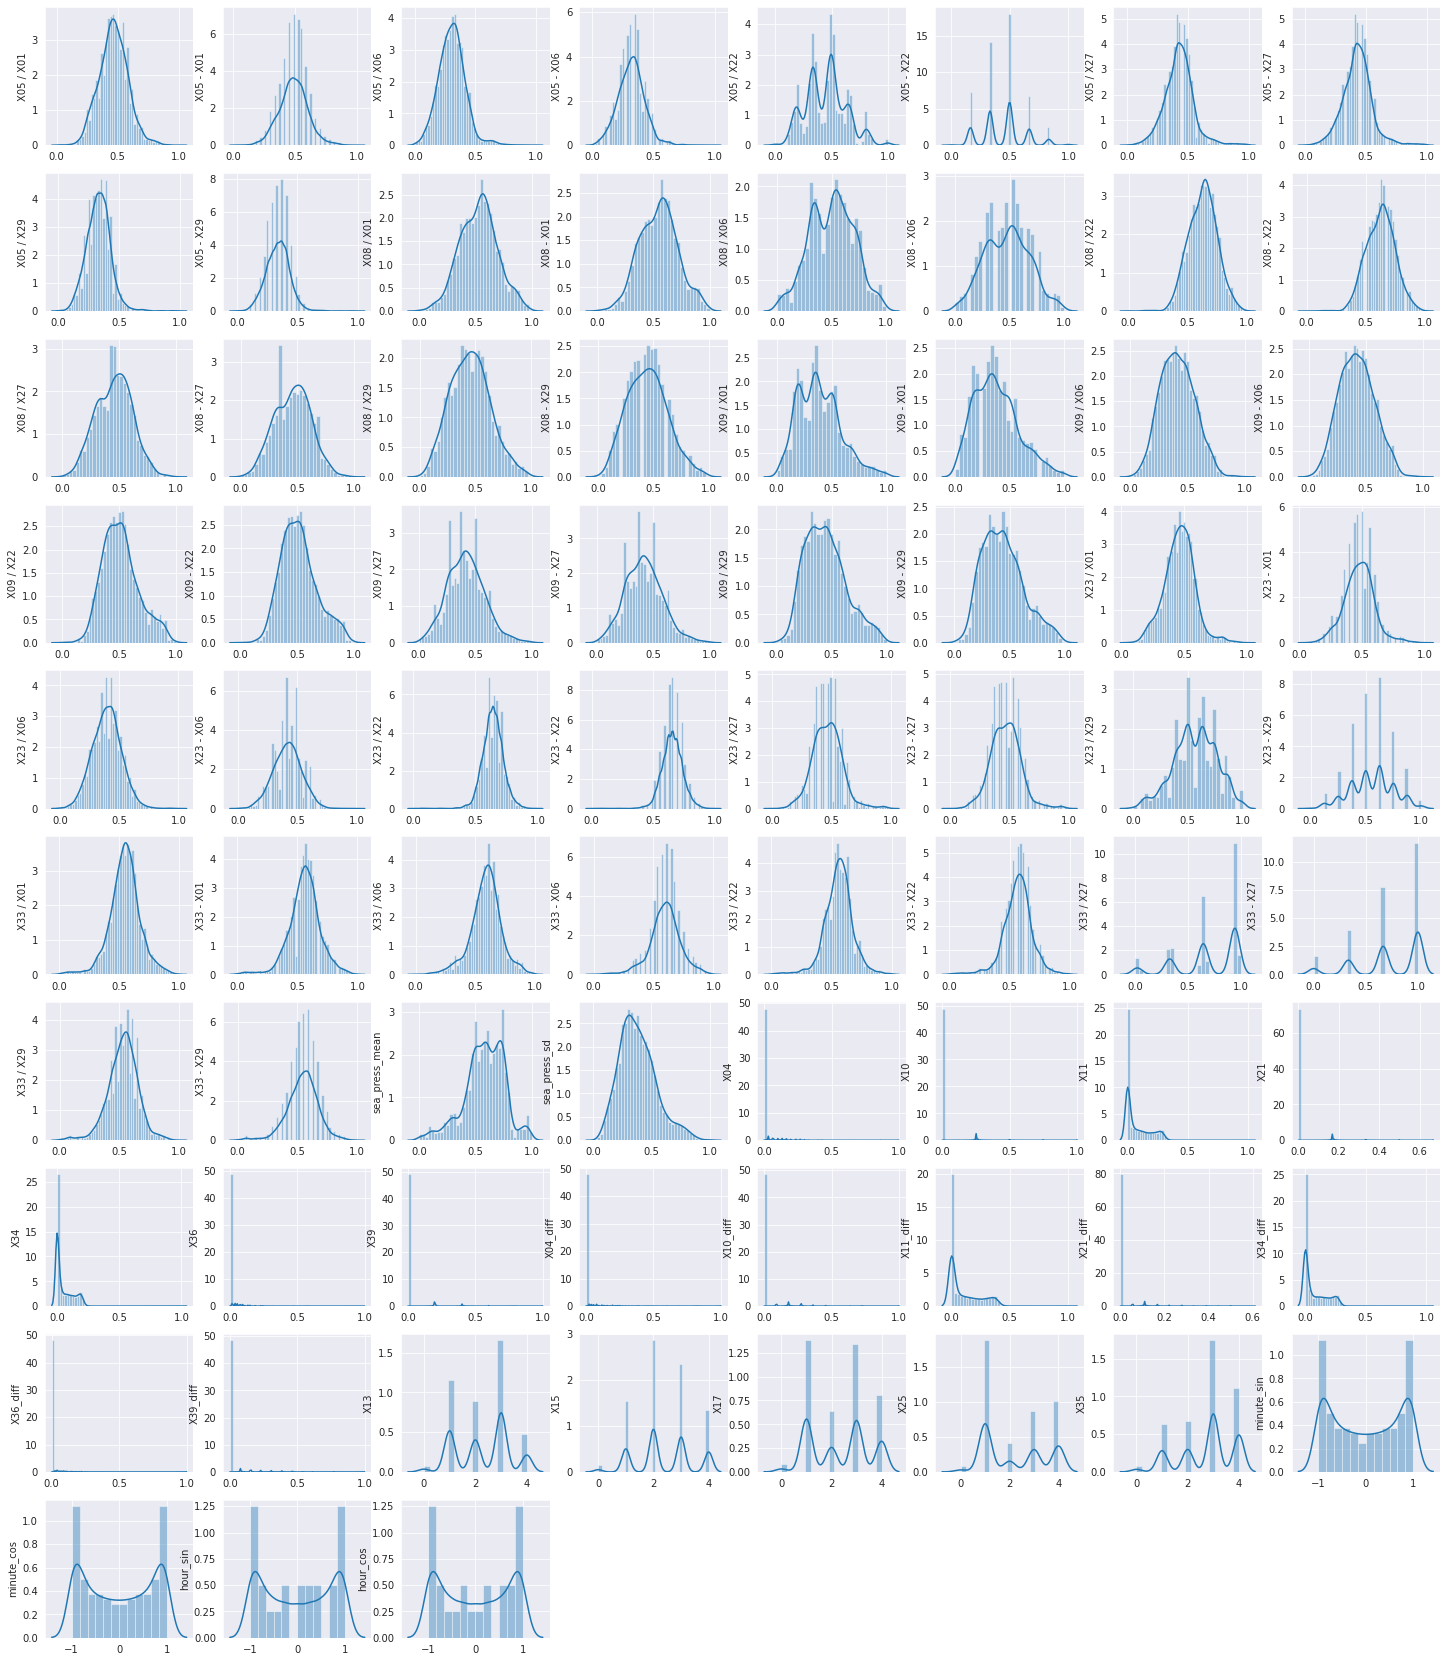

In [13]:
sns.set_style("darkgrid")
plt.figure(figsize=(25,30))
for i, col in enumerate(train2.columns[20:]):
    plt.subplot(10,8,i+1)
    sns.distplot(train2[col])
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

In [0]:
import tensorflow.keras
import tensorflow as tf
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Input, Activation, BatchNormalization
from tensorflow.keras import optimizers

train_reshaped = np.expand_dims(train2 ,axis=1)
train_y_high = train_y
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

def mse_keras(y_true, y_pred):
    score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

model2 = Sequential()
model2.add(LSTM(150, return_sequences= True,input_shape=train_reshaped.shape[-2:]))
model2.add(LSTM(50, return_sequences= False,activation='linear',))
model2.add(Dense(50,activation='linear'))
# model.add(Dense(50,activation='linear'))
model2.add(Dense(18,activation='linear'))
adam = optimizers.Adam(lr=0.0005)

model2.compile(optimizer=adam, loss='mse', metrics=[mse_keras])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 150)            137400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                40200     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_7 (Dense)              (None, 18)                918       
Total params: 181,068
Trainable params: 181,068
Non-trainable params: 0
_________________________________________________________________


In [0]:
epochs = 100
batch_size = 144
epoch_size = train2.shape[0]

early_stop = tf.keras.callbacks.EarlyStopping(patience=15, monitor='loss')

ckpt_dir = '/gdrive/My Drive/ckpt1'
ckpt_path = ckpt_dir + '/model1_{epoch:02d}_valloss{val_loss:.2f}.hdf5'
ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='loss', verbose=0, save_best_only=True, mode='min')

# lr_finder = LRFinder(min_lr=1e-5, 
#                      max_lr=1e-3, 
#                      steps_per_epoch=np.ceil(epoch_size/batch_size), 
#                      epochs=epochs)
model2.fit(train_reshaped, train_y_high, batch_size=144, epochs=100, shuffle=False,callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.8, patience = 8, min_lr = 3e-5,
                                      verbose = 1),early_stop],validation_split=0.1)

Epoch 1/100
27/27 [==============================] - 0s 5ms/step - loss: 1.0675 - mse_keras: 0.8876 - val_loss: 1.9796 - val_mse_keras: 1.8044 - lr: 3.0000e-05
Epoch 2/100
27/27 [==============================] - 0s 5ms/step - loss: 1.0674 - mse_keras: 0.8875 - val_loss: 1.9796 - val_mse_keras: 1.8043 - lr: 3.0000e-05
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 1.0673 - mse_keras: 0.8875 - val_loss: 1.9796 - val_mse_keras: 1.8044 - lr: 3.0000e-05
Epoch 4/100
27/27 [==============================] - 0s 5ms/step - loss: 1.0671 - mse_keras: 0.8873 - val_loss: 1.9795 - val_mse_keras: 1.8044 - lr: 3.0000e-05
Epoch 5/100
27/27 [==============================] - 0s 5ms/step - loss: 1.0670 - mse_keras: 0.8871 - val_loss: 1.9795 - val_mse_keras: 1.8044 - lr: 3.0000e-05
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 1.0669 - mse_keras: 0.8870 - val_loss: 1.9794 - val_mse_keras: 1.8041 - lr: 3.0000e-05
Epoch 7/100
27/27 [=====================

In [0]:
concat = train1

for column in ['Y11','Y09' ,'Y15', 'Y16']:
    concat = pd.concat([concat, train[column]], axis = 1)
    
concat = concat.head(144 * 30)
melted_concat = pd.melt(concat, concat.columns[:-4])
del melted_concat['variable']

melted_array = melted_concat.to_numpy()

seq_steps = 12

dataset = tf.data.Dataset.from_tensor_slices(melted_array)
dataset = dataset.window(seq_steps, shift = 1, drop_remainder = True)
dataset = dataset.flat_map(lambda window: window.batch(12))
dataset = dataset.batch(24).repeat()

def getPatial(batch):
    return (batch[:, :, :-1], batch[:, :, -1])

dataset = dataset.map(getPatial)

In [0]:
def get_model():
    inputs = Input(shape = (seq_steps, 78))
    lstm = LSTM(150)(inputs)
    x = Dense(256, activation = 'linear')(lstm)
    x = Dense(128, activation = 'linear')(x)
    x = Dense(1)(x)
    
    model = Model(inputs = inputs, outputs = x)
    
    # mae or mse
    model.compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = ['mse'])

    return model

In [0]:
# model22 = get_model()
model22.fit(dataset, epochs = 100, steps_per_epoch = melted_array.shape[0] // 24 , callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor = 0.8, patience = 5, min_lr = 1e-5,
                                      verbose = 1),early_stop])

Epoch 1/100
720/720 [==============================] - 3s 4ms/step - loss: 5.4441 - mse: 5.4474 - lr: 3.2768e-04
Epoch 2/100
720/720 [==============================] - 3s 4ms/step - loss: 5.3707 - mse: 5.3739 - lr: 3.2768e-04
Epoch 3/100
720/720 [==============================] - 3s 4ms/step - loss: 5.1601 - mse: 5.1632 - lr: 3.2768e-04
Epoch 4/100
720/720 [==============================] - 3s 4ms/step - loss: 5.3555 - mse: 5.3587 - lr: 3.2768e-04
Epoch 5/100
720/720 [==============================] - 3s 4ms/step - loss: 5.1176 - mse: 5.1206 - lr: 3.2768e-04
Epoch 6/100
720/720 [==============================] - 3s 4ms/step - loss: 5.2701 - mse: 5.2732 - lr: 3.2768e-04
Epoch 7/100
720/720 [==============================] - 3s 4ms/step - loss: 4.9903 - mse: 4.9933 - lr: 3.2768e-04
Epoch 8/100
720/720 [==============================] - 3s 4ms/step - loss: 5.1630 - mse: 5.1661 - lr: 3.2768e-04
Epoch 9/100
720/720 [==============================] - 3s 4ms/step - loss: 5.0377 - mse: 5.0407 

In [0]:
test_concat = pd.concat([train1, test1], axis = 0)
test_concat = test_concat.to_numpy()

test_ds = tf.data.Dataset.from_tensor_slices(test_concat)
test_ds = test_ds.window(seq_steps, shift = 1, drop_remainder = True)
test_ds = test_ds.flat_map(lambda window: window.batch(12))

test_X = []

for i in test_ds.take(16260):
    test_X.append(i.numpy())
test_X = np.array(test_X[-11520:])

In [0]:
transfer_x = train1.tail(432).to_numpy()
transfer_y = train18.tail(432).to_numpy()

transfer_ds = tf.data.Dataset.from_tensor_slices(transfer_x)
transfer_ds = transfer_ds.window(seq_steps, shift = 1, drop_remainder = True)
transfer_ds = transfer_ds.flat_map(lambda window:window.batch(12))

label_ds = tf.data.Dataset.from_tensor_slices(transfer_y)

model_ds = tf.data.Dataset.zip((transfer_ds, label_ds))
model_ds = model_ds.batch(24).repeat()

In [0]:
ft_hs = model22.fit(model_ds, epochs = , steps_per_epoch = (432 // 24) + 1)

Epoch 1/11
19/19 [==============================] - 0s 5ms/step - loss: 1.7249 - mse: 1.7620
Epoch 2/11
19/19 [==============================] - 0s 4ms/step - loss: 1.5155 - mse: 1.5489
Epoch 3/11
19/19 [==============================] - 0s 4ms/step - loss: 1.7198 - mse: 1.7583
Epoch 4/11
19/19 [==============================] - 0s 5ms/step - loss: 1.3777 - mse: 1.4079
Epoch 5/11
19/19 [==============================] - 0s 4ms/step - loss: 1.1792 - mse: 1.2045
Epoch 6/11
19/19 [==============================] - 0s 4ms/step - loss: 1.1312 - mse: 1.1552
Epoch 7/11
19/19 [==============================] - 0s 4ms/step - loss: 1.0541 - mse: 1.0762
Epoch 8/11
19/19 [==============================] - 0s 4ms/step - loss: 0.9867 - mse: 1.0071
Epoch 9/11
19/19 [==============================] - 0s 4ms/step - loss: 1.0009 - mse: 1.0216
Epoch 10/11
19/19 [==============================] - 0s 4ms/step - loss: 0.9085 - mse: 0.9269
Epoch 11/11
19/19 [==============================] - 0s 4ms/step - lo

In [0]:
preds = model22.predict(test_X)

In [0]:
sample_sub["Y18"] = preds
sample_sub.to_csv('/gdrive/My Drive/Data/tem_sample1.csv',index=False)

In [0]:
def high_corr(df, col, ratio):
    Y_corr = df.corr()
    Y_high = Y_corr.loc[:,(Y_corr[col]> ratio)|(Y_corr[col] < -ratio)].columns
    return Y_high
Y_high = high_corr(y_train, "Y18", 0.7)
print(Y_high[:-1])

Index(['X00', 'X07', 'X12', 'X18', 'X20', 'X24', 'X28', 'X30', 'X31', 'X32',
       'X37', 'X38', 'X05-X22', 'X08-X01', 'X08-X06', 'X08-X27', 'X08-X29',
       'X09-X01', 'X23-X29', 'X11', 'X34', 'X11_diff', 'X34_diff',
       'minute_cos', 'hour_cos'],
      dtype='object')


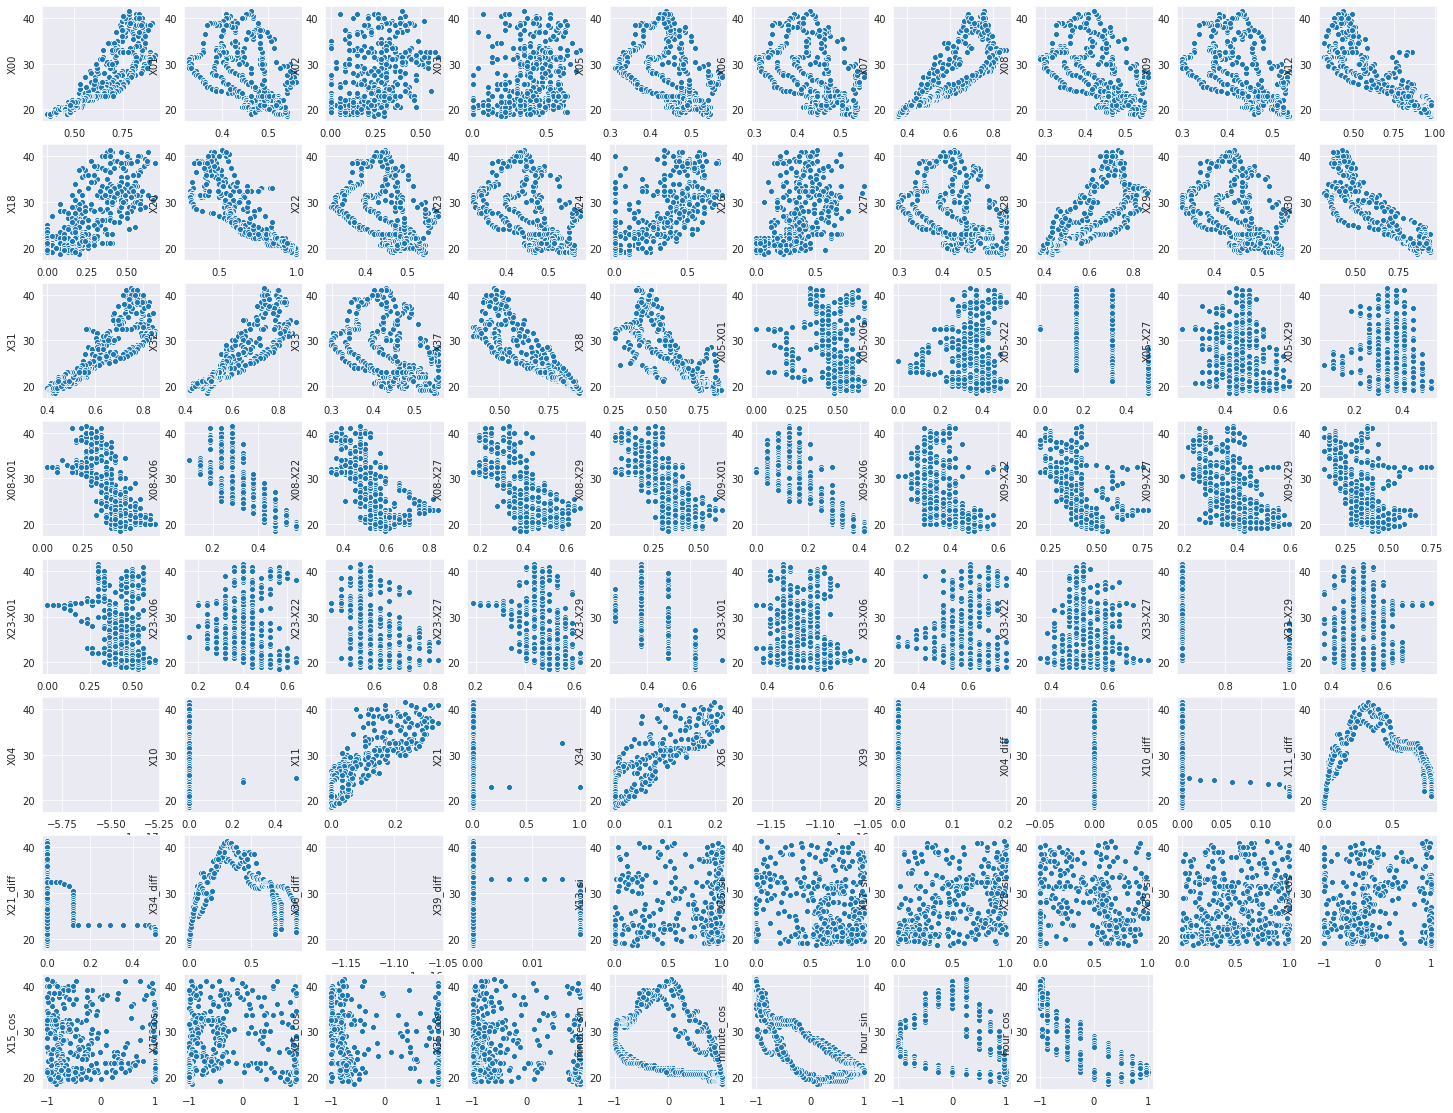

In [0]:
sns.set_style("darkgrid")
plt.figure(figsize=(25,25))
for i, col in enumerate(train3.columns):
    plt.subplot(10,10,i+1)
    sns.scatterplot(train3[col],train18)
    plt.title("")
    plt.xlabel("")
    plt.ylabel(col)

In [0]:
y_train = pd.concat([train3,y017],axis=1,sort=False)

In [18]:
train2.loc[:,"X05 / X01":"X33 - X27"].corr()

,X05 / X01,X05 - X01,X05 / X06,X05 - X06,X05 / X22,X05 - X22,X05 / X27,X05 - X27,X05 / X29,X05 - X29,X08 / X01,X08 - X01,X08 / X06,X08 - X06,X08 / X22,X08 - X22,X08 / X27,X08 - X27,X08 / X29,X08 - X29,X09 / X01,X09 - X01,X09 / X06,X09 - X06,X09 / X22,X09 - X22,X09 / X27,X09 - X27,X09 / X29,X09 - X29,X23 / X01,X23 - X01,X23 / X06,X23 - X06,X23 / X22,X23 - X22,X23 / X27,X23 - X27,X23 / X29,X23 - X29,X33 / X01,X33 - X01,X33 / X06,X33 - X06,X33 / X22,X33 - X22,X33 / X27,X33 - X27
X05 / X01,1.000000,0.976273,0.546319,0.537201,0.529135,0.498593,0.108176,0.107711,0.463707,0.455740,0.529759,0.501540,0.450759,0.420995,0.062948,0.058539,0.052444,0.051922,0.205329,0.197336,0.178876,0.149438,-0.029178,-0.045079,-0.306306,-0.307607,-0.232799,-0.233379,-0.183484,-0.187388,0.779060,0.748442,0.572901,0.556269,0.076812,0.067486,0.039170,0.038354,0.550000,0.526086,0.538750,0.519304,0.558626,0.536557,0.098332,0.093492,0.453314,0.450962
X05 - X01,0.976273,1.000000,0.514588,0.543124,0.531662,0.546086,0.099593,0.100404,0.451182,0.464812,0.547037,0.545728,0.461602,0.466481,0.096001,0.101222,0.074802,0.075925,0.233854,0.237933,0.214161,0.214168,-0.008750,0.000457,-0.263382,-0.256407,-0.206622,-0.206288,-0.148215,-0.142763,0.764675,0.776813,0.540174,0.572800,0.087641,0.099683,0.034484,0.036114,0.543865,0.558887,0.529263,0.537115,0.530266,0.550168,0.103585,0.110560,0.430823,0.440614
X05 / X06,0.546319,0.514588,1.000000,0.984990,0.424281,0.385742,0.719191,0.718481,0.812316,0.798691,-0.136186,-0.155861,0.341333,0.296962,-0.386878,-0.389779,0.188794,0.186363,-0.069543,-0.079507,0.114373,0.085768,0.475522,0.441579,-0.128228,-0.132907,0.311187,0.309336,0.161708,0.151756,0.089053,0.054974,0.816204,0.781805,-0.393923,-0.403830,0.535435,0.533329,0.478181,0.440387,-0.255767,-0.277564,0.206976,0.163122,-0.594579,-0.600078,0.416994,0.405914
X05 - X06,0.537201,0.543124,0.984990,1.000000,0.432378,0.429417,0.717757,0.718071,0.810816,0.814358,-0.120334,-0.118759,0.354907,0.337807,-0.363010,-0.358244,0.207890,0.206761,-0.046198,-0.046608,0.144619,0.139227,0.495181,0.481027,-0.096540,-0.094625,0.332821,0.331694,0.190071,0.187527,0.082743,0.082492,0.799142,0.803872,-0.387784,-0.380698,0.535241,0.535083,0.479697,0.472693,-0.261721,-0.261925,0.189460,0.178791,-0.593754,-0.589863,0.404349,0.402907
X05 / X22,0.529135,0.531662,0.424281,0.432378,1.000000,0.978385,0.352417,0.353038,0.554526,0.557364,0.667247,0.655949,0.868282,0.850231,0.587989,0.584026,0.656084,0.656146,0.721761,0.715230,0.780432,0.753056,0.640825,0.630957,0.542187,0.537729,0.494120,0.493978,0.588471,0.583775,0.415154,0.412468,0.478688,0.486229,0.361347,0.358369,0.386945,0.387792,0.828431,0.819991,0.054576,0.052421,0.082965,0.079818,-0.065009,-0.064672,0.409825,0.411164
X05 - X22,0.498593,0.546086,0.385742,0.429417,0.978385,1.000000,0.335240,0.337061,0.530607,0.553885,0.669212,0.683665,0.857934,0.873187,0.604090,0.609383,0.660005,0.661639,0.730955,0.736049,0.794145,0.795370,0.642606,0.656832,0.566453,0.570002,0.504149,0.504890,0.605062,0.609389,0.395010,0.432917,0.437608,0.491743,0.361971,0.379373,0.371916,0.375072,0.803375,0.832097,0.047573,0.071343,0.057044,0.093810,-0.057604,-0.046057,0.379848,0.392698
X05 / X27,0.108176,0.099593,0.719191,0.717757,0.352417,0.335240,1.000000,0.999974,0.739736,0.735201,-0.188833,-0.191053,0.339437,0.314826,-0.192607,-0.192430,0.622640,0.620222,0.117856,0.111924,0.214106,0.201417,0.606622,0.585729,0.183848,0.180844,0.736651,0.735057,0.442535,0.435293,-0.286452,-0.295567,0.472858,0.457599,-0.407569,-0.407823,0.892224,0.891312,0.381981,0.362317,-0.767447,-0.773755,-0.511480,-0.536876,-0.941035,-0.940496,0.289718,0.280455
X05 - X27,0.107711,0.100404,0.718481,0.718071,0.353038,0.337061,0.999974,1.000000,0.739783,0.735841,-0.187982,-0.189487,0.340238,0.316553,-0.191302,-0.190871,0.623697,0.621334,0.119164,0.113553,0.215745,0.203829,0.607742,0.587526,0.185583,0.182801,0.737845,0.736289,0.444113,0.437126,-0.286808,-0.294780,0.472019,0.458089,-0.407215,-0.406901,0.892242,0.891412,0.38

In [0]:
# model1.load_weights('/gdrive/My Drive/ckpt2/model2_58_valloss2.75.hdf5')
yt017 = model.predict(np.expand_dims(test1,axis=1))
yt017 = pd.DataFrame(yt017,columns= train_y.columns)
# yt017 = scaler1.transform(yt017)
yt18 = model1.predict(np.expand_dims(yt017[Y_high.tolist()],axis=1))

In [0]:
sample_sub["Y18"] = yt18
sample_sub.to_csv('/gdrive/My Drive/Data/sample3.csv',index=False)

In [19]:
y_high_pred = ["Y00","Y01","Y02","Y03","Y04","Y05","Y06","Y09","Y10","Y11","Y13","Y15","Y16","Y17"]

# 7,8 빼기

train3_y = pd.DataFrame()
test_y = pd.DataFrame()
for col in y_high_pred:
  lgb_train = lgb.Dataset(train2, label=train_y[col])

  lgb_param = {
    "objective":"regression",
    "metrics":"mse",
    "learning_rate":0.005,
    'num_leaves': 80,
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.9, 
    'n_jobs' : -1
  }

  print("start "+col)
  cv_result = lgb.cv(
    lgb_param,
    lgb_train,
    num_boost_round=7000,
    nfold=5,
    early_stopping_rounds=10,
    stratified=False,
    verbose_eval=500
  )
  if cv_result["l2-mean"][-1]<0.6:
    print("train start")
    lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result["l2-mean"])
    )
    train3_y[col] = lgb_model.predict(train3)
    test_y[col] = lgb_model.predict(test1)
  else:
    print("skip")

start Y00
[500]	cv_agg's l2: 0.214255 + 0.0146283
[1000]	cv_agg's l2: 0.0647158 + 0.00459763
[1500]	cv_agg's l2: 0.0593373 + 0.00367879
[2000]	cv_agg's l2: 0.0582609 + 0.00344562
[2500]	cv_agg's l2: 0.0578565 + 0.0034004
train start
start Y01
[500]	cv_agg's l2: 0.733658 + 0.0200838
[1000]	cv_agg's l2: 0.230402 + 0.00502222
[1500]	cv_agg's l2: 0.203488 + 0.00452232
[2000]	cv_agg's l2: 0.196609 + 0.00451843
[2500]	cv_agg's l2: 0.193426 + 0.00446959
[3000]	cv_agg's l2: 0.191663 + 0.0044765
[3500]	cv_agg's l2: 0.190574 + 0.00441745
[4000]	cv_agg's l2: 0.18986 + 0.00443525
[4500]	cv_agg's l2: 0.189366 + 0.00436856
[5000]	cv_agg's l2: 0.189037 + 0.00435193
[5500]	cv_agg's l2: 0.188796 + 0.00433321
[6000]	cv_agg's l2: 0.188629 + 0.00432354
train start
start Y02
[500]	cv_agg's l2: 0.729767 + 0.0308969
[1000]	cv_agg's l2: 0.24447 + 0.0163596
[1500]	cv_agg's l2: 0.217748 + 0.0138585
[2000]	cv_agg's l2: 0.21091 + 0.0129242
[2500]	cv_agg's l2: 0.207593 + 0.0125667
[3000]	cv_agg's l2: 0.205867 + 0.

In [57]:
test_y.describe()

,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y09,Y10,Y11,Y13,Y15,Y16
count,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000
mean,25.804478,29.306525,29.577023,26.684040,26.675661,28.730813,25.813337,27.437884,30.374273,30.264913,25.332306,25.066802,27.179035
std,3.243704,5.827143,5.864580,2.570272,2.690294,6.201091,4.555643,6.577288,8.202695,8.877941,4.725398,4.643521,5.862404
min,17.739373,16.165387,16.217855,21.026042,20.723456,15.999430,15.175432,13.614361,13.850082,12.898978,15.567603,15.362177,14.815943
25%,23.113245,24.435597,24.678673,24.635041,24.529264,24.167243,22.316922,22.324464,23.733111,23.651006,21.545039,21.514596,22.601242
50%,26.000208,29.410203,29.731376,26.184656,26.069581,28.080751,25.607887,26.333862,29.428780,28.928532,24.481617,24.214279,26.306707
75%,28.280693,34.160851,34.493255,29.109350,29.097270,32.959299,28.572649,32.800812,37.012083,36.924141,28.237679,28.161869,31.630444
max,31.543060,39.719489,39.188612,31.935730,32.427369,49.864031,41.182045,41.185877,47.172551,52.083315,36.729489,39.189183,39.974371


In [0]:
train2_new = pd.concat([train2,train_y[cols]],axis=1)
train_new = pd.concat([train3,train3_y],axis=1)
test_y.index = test1.index
cols = train3_y.columns
test_new = pd.concat([test1,test_y],axis=1)

In [0]:
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error
def lgb_cv(num_leaves, learning_rate, n_estimators, reg_alpha, reg_lambda, min_split_gain, min_child_weight,min_child_samples, colsample_bytree, x_data=None, y_data=None, n_splits=5, output='score'):
    score = 0
    kf = KFold(n_splits=n_splits)
    models = []
    for train_index, valid_index in kf.split(x_data):
        x_train, y_train = x_data.iloc[train_index,:], y_data[train_index]
        x_valid, y_valid = x_data.iloc[valid_index,:], y_data[valid_index]
        
        model = lgb.LGBMRegressor(
            num_leaves = int(num_leaves), 
            learning_rate = learning_rate, 
            n_estimators = int(n_estimators), 
            reg_alpha = reg_alpha, 
            reg_lambda = reg_lambda,
            min_split_gain= min_split_gain,
            min_child_weight = min_child_weight,
            min_child_samples = int(min_child_samples),
            colsample_bytree = np.clip(colsample_bytree, 0, 1), 
        )
        
        model.fit(x_train, y_train)
        models.append(model)
        
        pred = model.predict(x_valid)
        true = y_valid
        score -= mse_AIFrenz(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models
def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

In [21]:
!pip install bayesian-optimization

In [24]:
from functools import partial 
from bayes_opt import BayesianOptimization
func_fixed = partial(lgb_cv, x_data=train_new, y_data=train18, n_splits=5, output='score')
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (40, 150),    
        'learning_rate': (0.001, 0.01),  
        'n_estimators': (5000, 7000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 0.95),
    }, 
    random_state=4321            
)
lgbBO.maximize(init_points=5, n_iter=50)

|   iter    |  target   | colsam... | learni... | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.465    |  0.8571   |  0.008336 |  21.52    |  0.02935  |  0.02012  |  6.958e+0 |  84.69    |  0.7578   |  0.08924  |
|  2        | -3.541    |  0.881    |  0.00657  |  16.9     |  0.02261  |  0.06669  |  6.357e+0 |  144.5    |  0.2813   |  0.6199   |
|  3        | -3.526    |  0.8883   |  0.004603 |  24.14    |  0.09306  |  0.09489  |  5.751e+0 |  77.65    |  0.6648   |  0.04242  |
|  4        | -3.724    |  0.8732   |  0.004871 |  11.17    |  0.07689  |  0.08554  |  5.301e+0 |  51.13    |  0.271    |  0.03026  |
|  5        | -3.619    |  0.9338   |  0.006378 |  23.97    |  0.05006  |  0.03827  |  5.488e+0 |  106.2    |  0.3298   |  0.4617   |
|  6        | -3.467    |  0.8685   |  0.007767 |  21.02    | 

In [0]:
!pip install bayesian-optimization

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    params['min_split_gain'], 
    params['min_child_weight'],
    params['min_child_samples'],
    params['colsample_bytree'],
    x_data=train_new, y_data=train18, n_splits=10, output='model')
preds = []
for model in models:
    pred = model.predict(train2_new)
    preds.append(pred)
pred = np.mean(preds, axis=0)



In [0]:
preds = []
for model in models:
    pred1 = model.predict(test_new)
    preds.append(pred1)
pred1 = np.mean(preds, axis=0)

In [71]:
# train2_new.drop("Y18",axis=1,inplace=True)
func_fixed = partial(lgb_cv, x_data=train3, y_data=train18, n_splits=5, output='score')
lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (40, 150),    
        'learning_rate': (0.001, 0.01),  
        'n_estimators': (5000, 7000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 0.95),
    }, 
    random_state=4321            
)
lgbBO.maximize(init_points=5, n_iter=20)

|   iter    |  target   | colsam... | learni... | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -3.488    |  0.8571   |  0.008336 |  21.52    |  0.02935  |  0.02012  |  6.958e+0 |  84.69    |  0.7578   |  0.08924  |
|  2        | -3.6      |  0.881    |  0.00657  |  16.9     |  0.02261  |  0.06669  |  6.357e+0 |  144.5    |  0.2813   |  0.6199   |
|  3        | -3.679    |  0.8883   |  0.004603 |  24.14    |  0.09306  |  0.09489  |  5.751e+0 |  77.65    |  0.6648   |  0.04242  |
|  4        | -3.705    |  0.8732   |  0.004871 |  11.17    |  0.07689  |  0.08554  |  5.301e+0 |  51.13    |  0.271    |  0.03026  |
|  5        | -3.432    |  0.9338   |  0.006378 |  23.97    |  0.05006  |  0.03827  |  5.488e+0 |  106.2    |  0.3298   |  0.4617   |
|  6        | -3.644    |  0.9174   |  0.009571 |  12.32    | 

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'], 
    params['learning_rate'], 
    params['n_estimators'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    params['min_split_gain'], 
    params['min_child_weight'],
    params['min_child_samples'],
    params['colsample_bytree'],
    x_data=train_new, y_data=train18, n_splits=10, output='model')
preds = []
for model in models:
    pred = model.predict(train2_new)
    preds.append(pred)
pred = np.mean(preds, axis=0)
train2_new["Y18"] = np.round(pred,1)
train_new["Y18"] = train18

In [73]:
train_con = pd.concat([train2_new,train_new],axis=0,sort=False).reset_index(drop=True)
yy = train_con["Y18"]
train_con.drop("Y18",axis=1,inplace=True)
func_fixed1 = partial(lgb_cv, x_data=train_con, y_data=yy, n_splits=5, output='score')
lgbB1 = BayesianOptimization(
    func_fixed1, 
    {
        'num_leaves': (40, 150),    
        'learning_rate': (0.001, 0.01),  
        'n_estimators': (5000, 7000),                        
        'reg_alpha': (0.0001, 1),       
        'reg_lambda': (0.0001, 1), 
        'min_split_gain' : (0.001, 0.1),
        'min_child_weight' : (0.001, 0.1),
        'min_child_samples' : (10,25),
        'colsample_bytree': (0.85, 0.95),
    }, 
    random_state=4321            
)
lgbB1.maximize(init_points=5, n_iter=15)


params1 = lgbB1.max['params']

models1 = lgb_cv(
    params1['num_leaves'], 
    params1['learning_rate'], 
    params1['n_estimators'], 
    params1['reg_alpha'], 
    params1['reg_lambda'], 
    params1['min_split_gain'], 
    params1['min_child_weight'],
    params1['min_child_samples'],
    params1['colsample_bytree'],
    x_data=train_con, y_data=yy, n_splits=10, output='model')

|   iter    |  target   | colsam... | learni... | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.1237   |  0.8571   |  0.008336 |  21.52    |  0.02935  |  0.02012  |  6.958e+0 |  84.69    |  0.7578   |  0.08924  |
|  2        | -0.1196   |  0.881    |  0.00657  |  16.9     |  0.02261  |  0.06669  |  6.357e+0 |  144.5    |  0.2813   |  0.6199   |
|  3        | -0.1352   |  0.8883   |  0.004603 |  24.14    |  0.09306  |  0.09489  |  5.751e+0 |  77.65    |  0.6648   |  0.04242  |
|  4        | -0.12     |  0.8732   |  0.004871 |  11.17    |  0.07689  |  0.08554  |  5.301e+0 |  51.13    |  0.271    |  0.03026  |
|  5        | -0.1202   |  0.9338   |  0.006378 |  23.97    |  0.05006  |  0.03827  |  5.488e+0 |  106.2    |  0.3298   |  0.4617   |
|  6        | -0.117    |  0.9174   |  0.009571 |  12.32    | 

In [0]:
preds = []
for model in models1:
    pred2 = model.predict(test_new)
    preds.append(pred2)
pred2 = np.mean(preds, axis=0)

In [0]:
sample_sub["Y18"] = pred2
sample_sub.to_csv('/gdrive/My Drive/Data/tem_sample2.csv',index=False)